In [1]:
using TaylorIntegration
using TaylorModels: @taylorize
using Reachability
using MathematicalSystems
using LazySets

@taylorize function lorenz!(dx, x, params, t)
    local σ = 10.0
    local β = 8.0 / 3.0
    local ρ = 28.0
    dx[1] = σ * (x[2] - x[1])
    dx[2] = x[1] * (ρ - x[3]) - x[2]
    dx[3] = x[1] * x[2] - β * x[3]
    return dx
end

𝑆 = BlackBoxContinuousSystem(lorenz!, 3)
X0 = Hyperrectangle(low=[0.9, 0.0, 0.0], high=[1.1, 0.0, 0.0])
𝑃 = InitialValueProblem(𝑆, X0)

# reach mode
𝑂 = Options(:T=>10.0, :mode=>"reach")
sol = solve(𝑃, 𝑂, op=TMJets(:abs_tol=>1e-27, :orderT=>10, :orderQ=>2));

# check mode
#property=(t,x)->x[2] <= 2.75
#𝑂 = Options(:T=>7.0, :mode=>"check", :property=>property)
#solve(𝑃, 𝑂, op=TMJets(:abs_tol=>1e-10, :orderT=>10, :orderQ=>2));

In [3]:
using Plots

In [4]:
sol.Xk[1] # primer elemento: tiene el conjunto y tambien tiene el tiempo

ReachSet{Hyperrectangle{Float64,StaticArrays.SArray{Tuple{3},Float64,1,3},StaticArrays.SArray{Tuple{3},Float64,1,3}}}(Hyperrectangle{Float64,StaticArrays.SArray{Tuple{3},Float64,1,3},StaticArrays.SArray{Tuple{3},Float64,1,3}}([1.0, 0.0, 0.0], [0.10000000000000009, 0.0, 0.0]), 0.0, 0.0001494302698491679)

In [5]:
set(sol.Xk[1])

Hyperrectangle{Float64,StaticArrays.SArray{Tuple{3},Float64,1,3},StaticArrays.SArray{Tuple{3},Float64,1,3}}([1.0, 0.0, 0.0], [0.10000000000000009, 0.0, 0.0])

In [6]:
dim(set(sol.Xk[1]))

3

In [7]:
sol_proj = project(sol); # aca proyecto con la funcion de Reachability

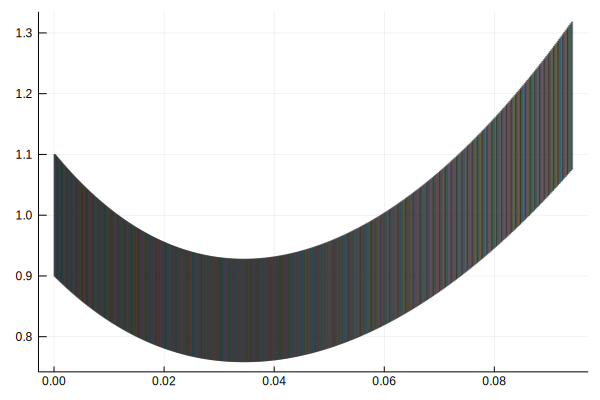

In [8]:
plot([set(sol_proj[i]) for i in eachindex(sol_proj)])

In [9]:
# pruebas

In [10]:
X0 = Hyperrectangle(low=[0.99, 0.0, 0.0], high=[1.01, 0.0, 0.0])
𝑃 = InitialValueProblem(𝑆, X0)

# reach mode
𝑂 = Options(:T=>5.0, :mode=>"reach")
sol = solve(𝑃, 𝑂, op=TMJets(:abs_tol=>1e-20, :orderT=>8, :orderQ=>2));

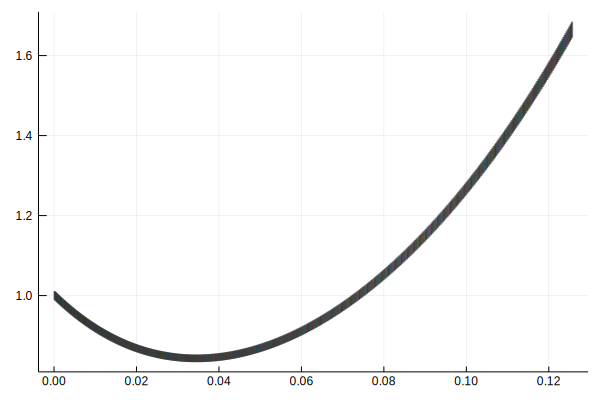

In [11]:
sol_proj = project(sol); # aca proyecto con la funcion de Reachability
plot([set(sol_proj[i]) for i in eachindex(sol_proj)])

In [12]:
X0 = Hyperrectangle(low=[0.99, 0.0, 0.0], high=[1.01, 0.0, 0.0])
𝑃 = InitialValueProblem(𝑆, X0)

# reach mode
𝑂 = Options(:T=>10.0, :mode=>"reach")
sol = solve(𝑃, 𝑂, op=TMJets(:abs_tol=>1e-20, :orderT=>8, :orderQ=>2));

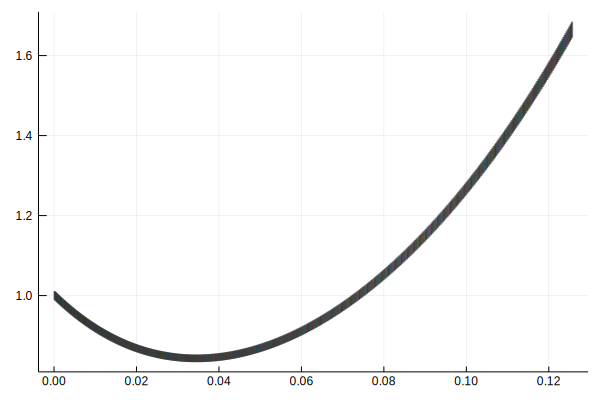

In [13]:
sol_proj = project(sol); # aca proyecto con la funcion de Reachability
plot([set(sol_proj[i]) for i in eachindex(sol_proj)])

In [14]:
X0 = Hyperrectangle(low=[0.99, 0.0, 0.0], high=[1.01, 0.0, 0.0])
𝑃 = InitialValueProblem(𝑆, X0)

# reach mode
𝑂 = Options(:T=>1.0, :mode=>"reach")
sol = solve(𝑃, 𝑂, op=TMJets(:abs_tol=>1e-20, :orderT=>8, :orderQ=>2));

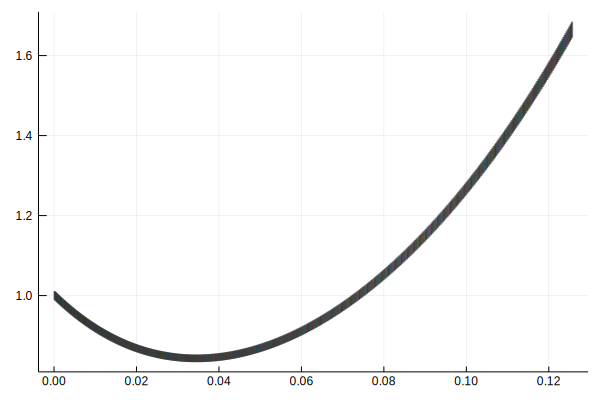

In [15]:
sol_proj = project(sol); # aca proyecto con la funcion de Reachability
plot([set(sol_proj[i]) for i in eachindex(sol_proj)])

In [20]:
sol.Xk[end].t_start

0.12552197333442608

In [21]:
sol.Xk[end].t_end

0.125783235285379